#  Phân tích và Phân cụm Dữ liệu Sinh viên

**Mục tiêu:** Áp dụng các phương pháp phân tích và thuật toán phân cụm để phát hiện nhóm đặc trưng trong tập dữ liệu sinh viên dựa trên kết quả học tập và hành vi học.

**Bộ dữ liệu:** Student_Performance.csv (bao gồm điểm số, thời gian học, hoạt động ngoại khóa, v.v.)


## A. Làm sạch dữ liệu

In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Đọc dữ liệu
df = pd.read_csv('Student_Performance.csv')
df.head()



,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


### Tiền xử lý dữ liệu
- Đưa cột `Extracurricular Activities` về dạng (0/1) để thực hiện chuẩn hóa và phân cụm.

In [74]:
dftrainWithoutPerform = df.copy(deep= True)
dftrain = df.copy(deep= True)
dftrain['Extracurricular Activities'] = dftrain['Extracurricular Activities'].map({'Yes': 1, 'No': 0})
dftrainWithoutPerform ['Extracurricular Activities'] = dftrainWithoutPerform['Extracurricular Activities'].map({'Yes': 1, 'No': 0})
dftrainWithoutPerform = dftrainWithoutPerform.drop(columns=['Performance Index'])
dftrainWithoutPerform.head(10)

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced
0,7,99,1,9,1
1,4,82,0,4,2
2,8,51,1,7,2
3,5,52,1,5,2
4,7,75,0,8,5
5,3,78,0,9,6
6,7,73,1,5,6
7,8,45,1,4,6
8,5,77,0,8,2
9,4,89,0,4,0


### 1. Xem thông tin tổng quan, loại dữ liệu và phân phối từng cột


- xem thông tin tổng quan, loại dữ liệu và phân phối từng cột.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


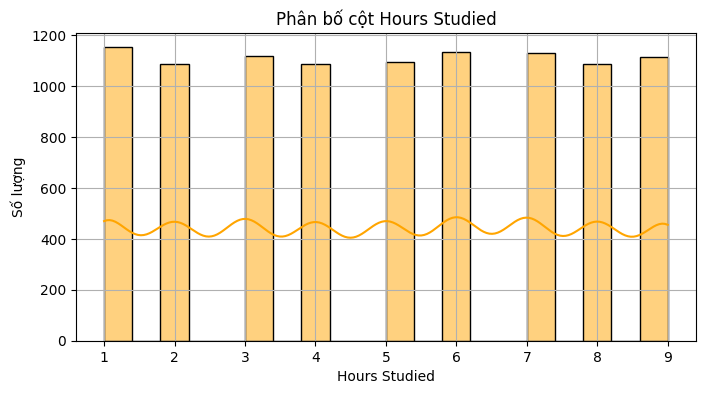

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


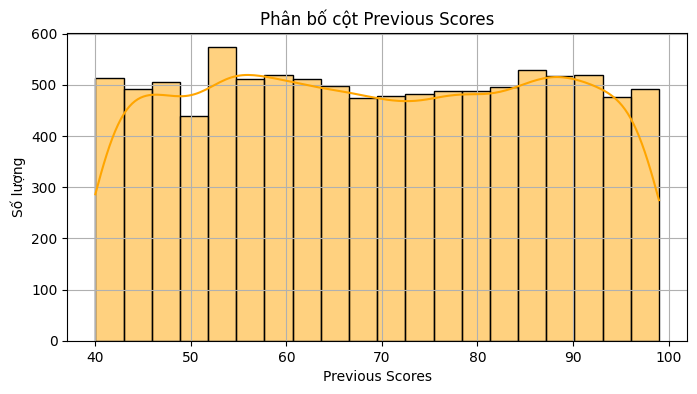

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


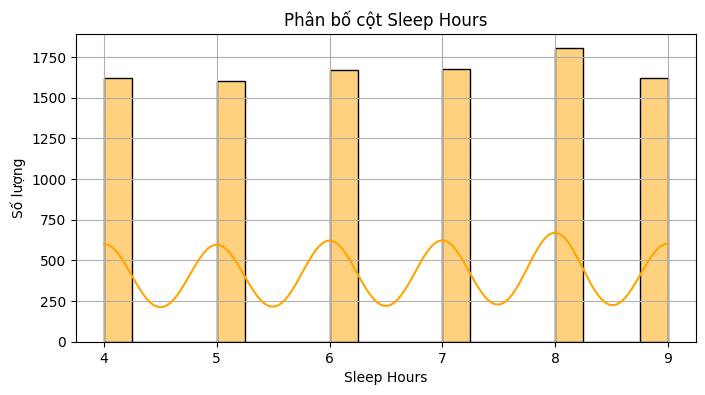

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


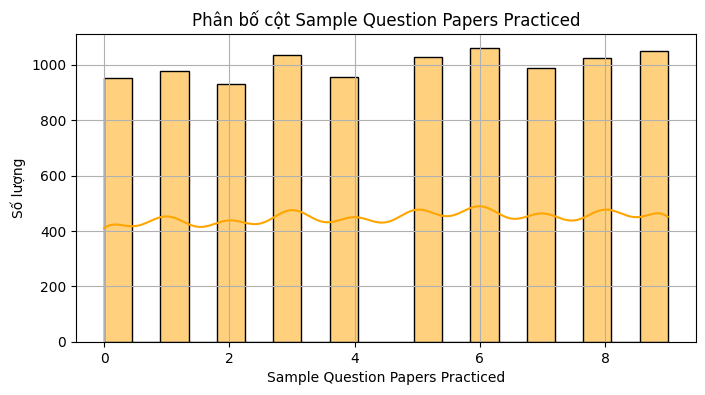

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


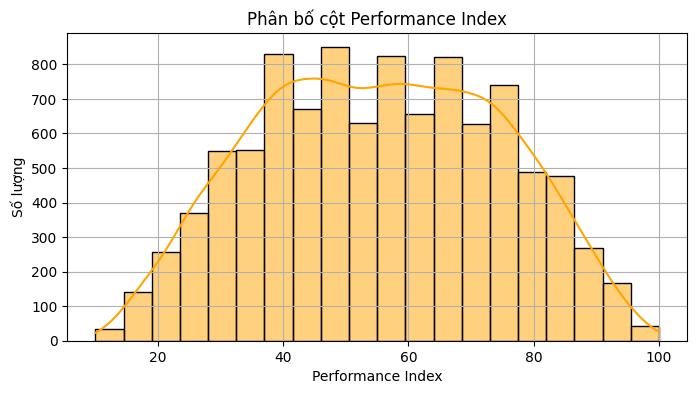

In [75]:
df.info()
df.describe()
df.isnull().sum()

# Phân phối dữ liệu
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Vẽ biểu đồ phân phối cho từng cột số
for col in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=col, kde=True, bins=20, color="orange", edgecolor="black")
    plt.title(f"Phân bố cột {col}")
    plt.xlabel(col)
    plt.ylabel("Số lượng")
    plt.grid(True)
    plt.show()



#### Phân tích qua biểu đồ và mô tả của dữ liệu
- Dựa vào kết quả mô tả và thuật toán, có thể thấy không có cột nào bị khuyết dữ liệu.
- cột `Extracurricular Activities` đang ở dạng text (Yes/No) => nên sẽ cần đưa về dạng (1/0) để có thể thực hiện thuật toán phân cụm.
- Dựa vào phân phối có thể thấy các cột có phân bố khá đồng đều vế số lượng mỗi giá trị, riêng cột `Performance Index` thì có phần phối gần với phân bố chuẩn.

### 2. kiểm tra các giá trị không hợp lệ

In [76]:
def classify_value(v):
    if pd.isna(v):
        return "missing"
    try:
        float(v)
        return "numeric"
    except (ValueError, TypeError):
        return "text"

report = {}
for col in df.columns:
    types = df[col].apply(classify_value)         
    majority_type = types.mode().iat[0]             
    invalid_count = (types != majority_type).sum()
    
    report[col] = {
        "invalid_count": invalid_count,
        "total_rows": len(df),
        "percent": round(invalid_count / len(df) * 100, 2),
        "majority_type": majority_type
    }

summary = (
    pd.DataFrame(report).T.reset_index()
      .rename(columns={'index': 'column'})
      .sort_values("invalid_count", ascending=False)
)

from IPython.display import display
print(" Báo cáo các giá trị không đúng định dạng ")
display(summary)

 Báo cáo các giá trị không đúng định dạng 


,column,invalid_count,total_rows,percent,majority_type
0,Hours Studied,0,10000,0.0,numeric
1,Previous Scores,0,10000,0.0,numeric
2,Extracurricular Activities,0,10000,0.0,text
3,Sleep Hours,0,10000,0.0,numeric
4,Sample Question Papers Practiced,0,10000,0.0,numeric
5,Performance Index,0,10000,0.0,numeric


#### đánh giá
- dựa vào báo cáo ta thấy dữ liệu không chưa các giá trị không hợp lệ.

### 3. Xem xét hệ số tương quan giữa các cột

<Axes: >

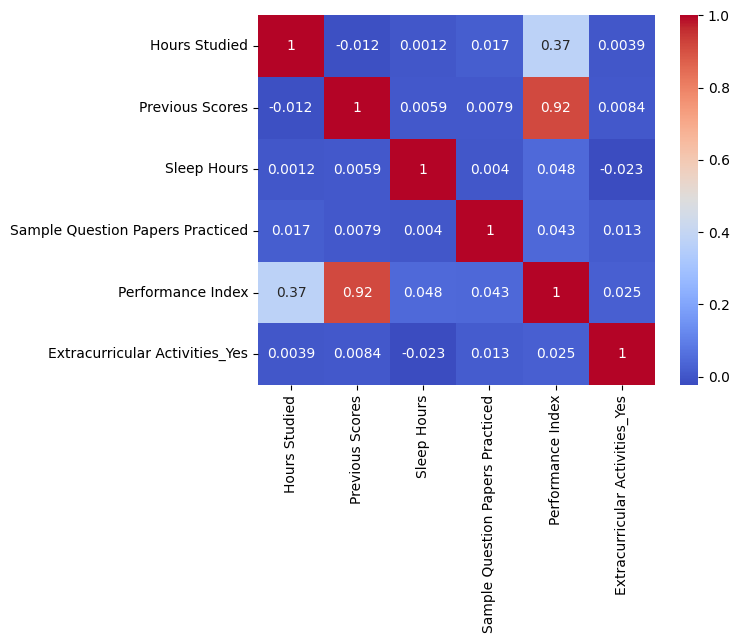

In [77]:
df_encoded = pd.get_dummies(df, drop_first=True) 
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm')

#### Phân tích
- dựa vào biểu đồ thì cột `Performance Index` và cột `Previous Scores` có hệ số tương quan mạnh (r= 0.92), khiến cụm bị kéo theo cùng một hướng có thể ảnh hướng đến kết quả của phân cụm => giải pháp là thử trường hợp bỏ 1 trong 2 cột hoặc không bỏ rồi so sánh kết quả để đem lại một kết quả tốt nhất.
- cột `Performance Index` và cột `Hours Studied` có hệ số tương quan vừa phải(r = 0.37).

### 4. kiểm tra giá trị outlier


- Phương pháp IQR và boxplot

In [78]:
numerical_columns = ['Hours Studied', 'Previous Scores', 'Sleep Hours',
                     'Sample Question Papers Practiced', 'Performance Index']

# Hàm phát hiện outlier theo IQR
def detect_outliers_iqr(df, columns):
    results = []
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        results.append({
            "Cột": col,
            "Số lượng ngoại lệ": len(outliers),
            "Tỉ lệ (%)": round(len(outliers)/len(df)*100, 2),
            "Ngưỡng dưới": round(lower_bound, 2),
            "Ngưỡng trên": round(upper_bound, 2)
        })
    return pd.DataFrame(results)

# Gọi hàm và in kết quả
outlier_summary = detect_outliers_iqr(df, numerical_columns)
print(outlier_summary)


                                Cột  Số lượng ngoại lệ  Tỉ lệ (%)  \
0                     Hours Studied                  0        0.0   
1                   Previous Scores                  0        0.0   
2                       Sleep Hours                  0        0.0   
3  Sample Question Papers Practiced                  0        0.0   
4                 Performance Index                  0        0.0   

   Ngưỡng dưới  Ngưỡng trên  
0         -3.0         13.0  
1          7.5        131.5  
2          0.5         12.5  
3         -5.5         14.5  
4         -6.5        117.5  


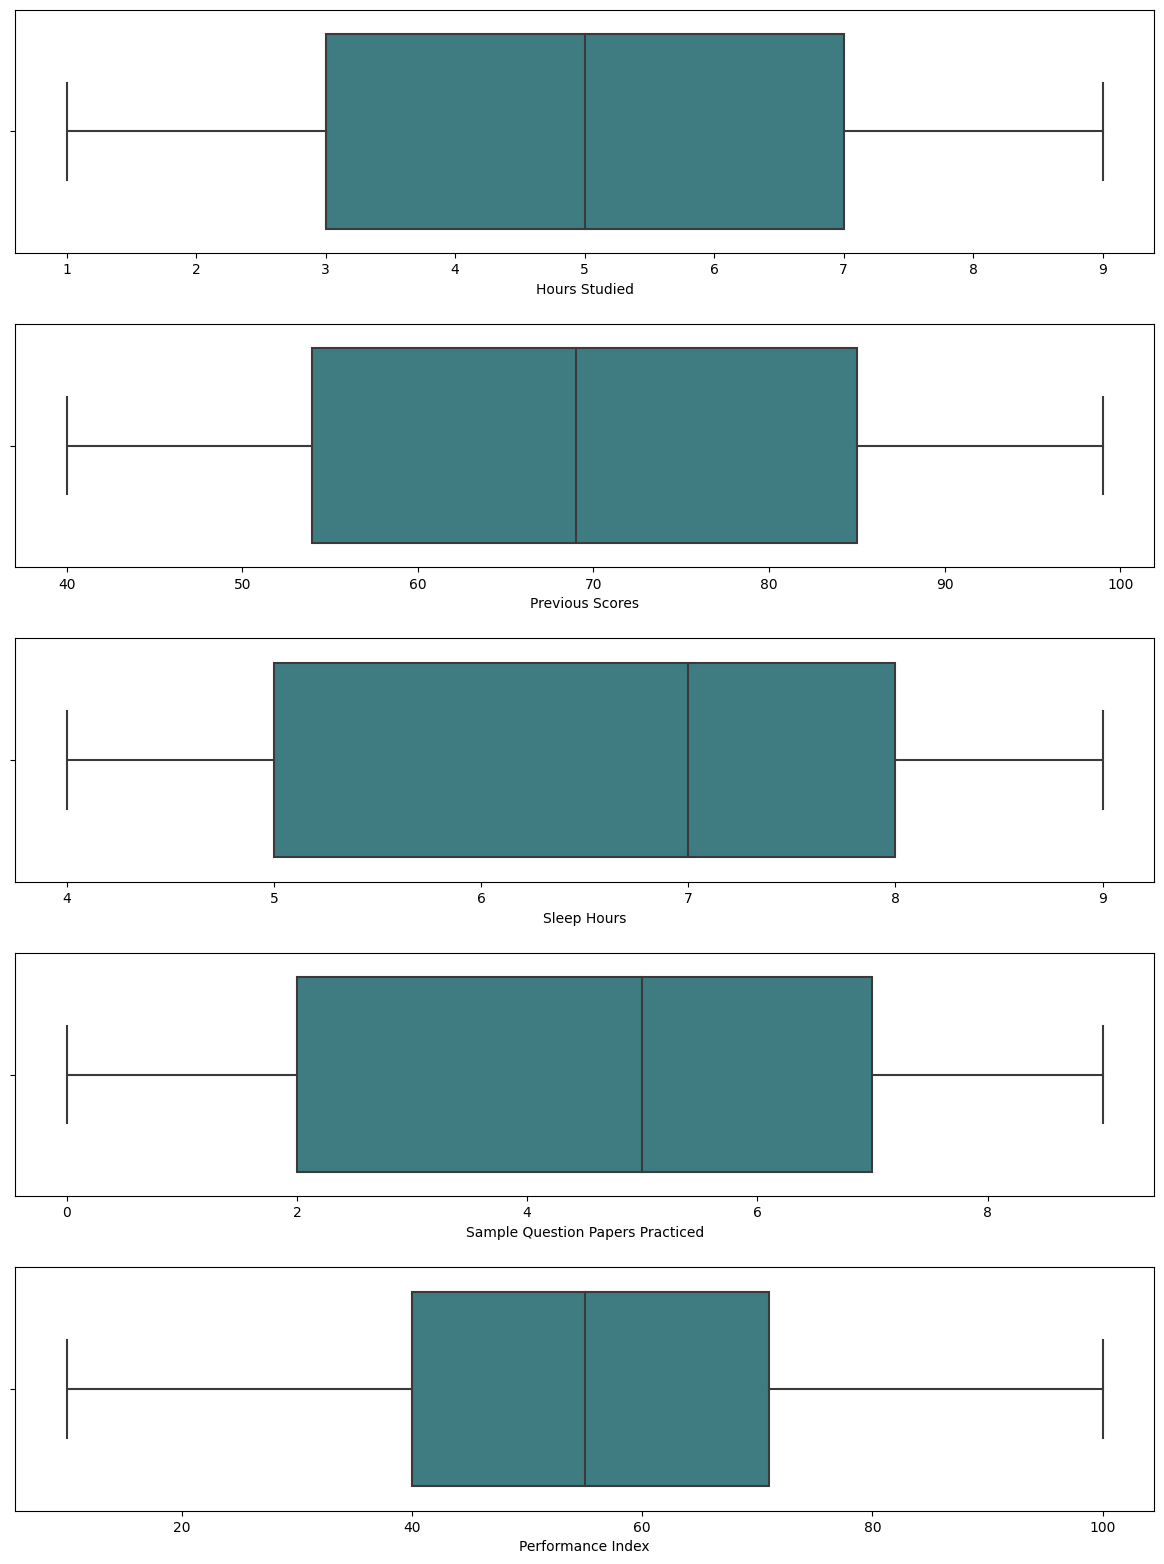

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load dữ liệu

# Tạo boxplot để phát hiện outlier cho từng cột
fig, axes = plt.subplots(5, 1, figsize=(12, 16), sharex=False, sharey=False)

sns.boxplot(x='Hours Studied', data=dftrain, palette='crest', ax=axes[0])
sns.boxplot(x='Previous Scores', data=dftrain, palette='crest', ax=axes[1])
sns.boxplot(x='Sleep Hours', data=dftrain, palette='crest', ax=axes[2])
sns.boxplot(x='Sample Question Papers Practiced', data=dftrain, palette='crest', ax=axes[3])
sns.boxplot(x='Performance Index', data=dftrain, palette='crest', ax=axes[4])

plt.tight_layout(pad=2.0)
plt.show()


#### Phân tích
- có thể thấy rằng không cột nào có giá trị outlier.

### 5. Đánh giá chung sau khi phân tích dữ liệu.
- Dữ liệu khá là đẹp và sạch, có phân bố phù hợp, không cần phải can thiệp làm sạch dữ liệu.
- Một vài vấn đề: 
    - dựa vào biểu đồ thì cột `Performance Index` và cột `Previous Scores` có hệ số tương quan mạnh (r= 0.92), khiến cụm bị kéo theo cùng một hướng có thể ảnh hướng đến kết quả của phân cụm cần xem xét, chạy hai trường hợp với việc giữa nguyên hoặc xóa đi 1 trong 2 cột, rồi rút ra kết quả tốt nhất.
- Vì dữ liệu không có giá trị outlier phân bố đẹp, nên thuật toán Kmean sẽ phù hợp với việc phân cụm với bộ dữ liệu này.


## B. Phân cụm dữ liệu

### 2. Chuẩn hóa dữ liệu
- vì dữ liệu không có outlier nên phương pháp chuẩn hóa `MinMaxScaler` vì nó dùng giá trị nhỏ nhất và giá trị lớn nhất để đưa dữ liệu về một khoảng nhất đinh, vì thế nó giữ nguyên được quan hệ tương đối giữa các điểm dữ liệu.

#### Công thức chuẩn hóa Min-Max:

$$
X_{scaled} = \frac{X - X_{min}}{X_{max} - X_{min}}
$$


In [80]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
data_scaled_minmax = minmax.fit_transform(dftrain)
dataWithout_Perform_minmax = minmax.fit_transform(dftrainWithoutPerform)
data_scaled_minmax.shape


(10000, 6)

### Chuẩn hóa bằng Z-Score

In [81]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled_std = scaler.fit_transform(dftrain)
datawithout_perform_std = scaler.fit_transform(dftrainWithoutPerform)
data_scaled_std.shape


(10000, 6)

In [82]:
data_scaled = data_scaled_std

### 3. Sử dụng phương pháp K-Mean để phân cụm.

#### 3.1 Xác định số lượng cụm tối ưu bằng Elbow 

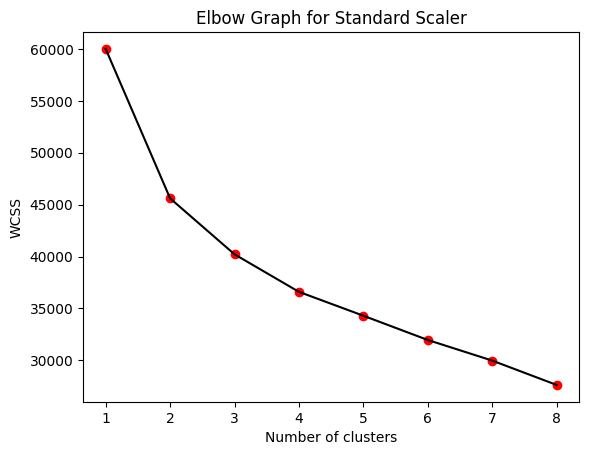

In [83]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Phương pháp Elbow để xác định số cụm tối ưu
wcss=[]
for i in range(1,9):
    kmeans = KMeans(n_clusters=i,random_state=2)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)
    
# Plot K values range vs WCSS to get Elbow graph for choosing K (no. of clusters)
plt.plot(range(1,9),wcss,color = 'black')
plt.scatter(range(1,9),wcss,color='red')
plt.title('Elbow Graph for Standard Scaler')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

#### 3.2 Silhouette Score 

In [84]:
n_clusters = [2,3,4,5,6,7,8,9,10] # number of clusters
clusters_inertia = [] # inertia of clusters
s_scores = [] # silhouette scores

for n in n_clusters:
    KM_est = KMeans(n_clusters=n, init='k-means++').fit(data_scaled)
    clusters_inertia.append(KM_est.inertia_)  # data for the elbow method
    silhouette_avg = silhouette_score(data_scaled, KM_est.labels_)
    s_scores.append(silhouette_avg) # data for the silhouette score method

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


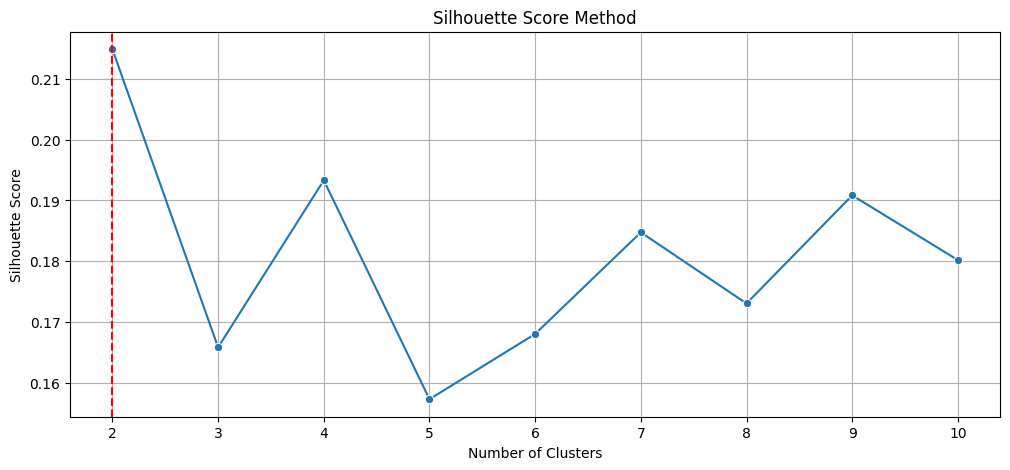

In [85]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.lineplot(x=n_clusters, y=s_scores, marker='o', ax=ax)

ax.set_title("Silhouette Score Method")
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Silhouette Score")
ax.axvline(2, ls="--", c="red")  # ví dụ: cụm tối ưu là 2
plt.grid()
plt.show()


In [86]:
clust_list = [2,3,4,5,6,7,8,9]

#  Silhouette score for stadardScaler applied on data.
for n_clusters in clust_list:
    clusterer1 = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels1 = clusterer1.fit_predict(data_scaled)
    sil_score1= silhouette_score(data_scaled, cluster_labels1)
    print("For n_clusters =", n_clusters,"The average silhouette_score is :", sil_score1)

For n_clusters = 2 The average silhouette_score is : 0.2149434398130374
For n_clusters = 3 The average silhouette_score is : 0.16434387346759127
For n_clusters = 4 The average silhouette_score is : 0.17588648222043757
For n_clusters = 5 The average silhouette_score is : 0.1676643242231397
For n_clusters = 6 The average silhouette_score is : 0.16412765604593063
For n_clusters = 7 The average silhouette_score is : 0.1726007391975376
For n_clusters = 8 The average silhouette_score is : 0.1785517747140676
For n_clusters = 9 The average silhouette_score is : 0.18097270806585697


### Phân tích kết quả:
- qua phương pháp Elbow và Silhouette Score cho thấy có thể phân 2,3 hoặc 4 cụm đều được, sau đây chúng ta sẽ chạy thử và so sánh kết quả, để lấy ra số cụm cần chia tốt nhất.

### 3.3 Build KMeans Cluster algorithm using K=(2, 3, 4) and Standard Scaler Applied Dataset

In [87]:
model_kmeans2 = KMeans(n_clusters=2, random_state=0, init='k-means++')
model_kmeans3 = KMeans(n_clusters=3, random_state=0, init='k-means++')
model_kmeans4 = KMeans(n_clusters=4, random_state=0, init='k-means++')
y_predict_kmeans2 = model_kmeans2.fit_predict(data_scaled)
y_predict_kmeans3 = model_kmeans3.fit_predict(data_scaled)
y_predict_kmeans4 = model_kmeans4.fit_predict(data_scaled)

In [88]:
dftrain_clu2 = dftrain.copy(deep=True)
dftrain_clu3= dftrain.copy(deep=True)
dftrain_clu4= dftrain.copy(deep=True)
dftrain_clu2['Kmeans_Label'] = model_kmeans2.labels_
dftrain_clu3['Kmeans_Label'] = model_kmeans3.labels_
dftrain_clu4['Kmeans_Label'] = model_kmeans4.labels_
dftrain_clu2.head(10)

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index,Kmeans_Label
0,7,99,1,9,1,91.0,1
1,4,82,0,4,2,65.0,1
2,8,51,1,7,2,45.0,0
3,5,52,1,5,2,36.0,0
4,7,75,0,8,5,66.0,1
5,3,78,0,9,6,61.0,1
6,7,73,1,5,6,63.0,1
7,8,45,1,4,6,42.0,0
8,5,77,0,8,2,61.0,1
9,4,89,0,4,0,69.0,1


##### KMeans Cluster algorithm using K= 2

In [89]:

dftrain_clu2.groupby('Kmeans_Label').agg(['mean'])

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
,mean,mean,mean,mean,mean,mean
Kmeans_Label,,,,,,
0,4.636544,54.886643,0.495046,6.484939,4.494055,39.288545
1,5.355874,84.275131,0.494550,6.577109,4.674203,71.457004


##### vẽ biểu đồ để phân tích số lượng mỗi cụm k= 2


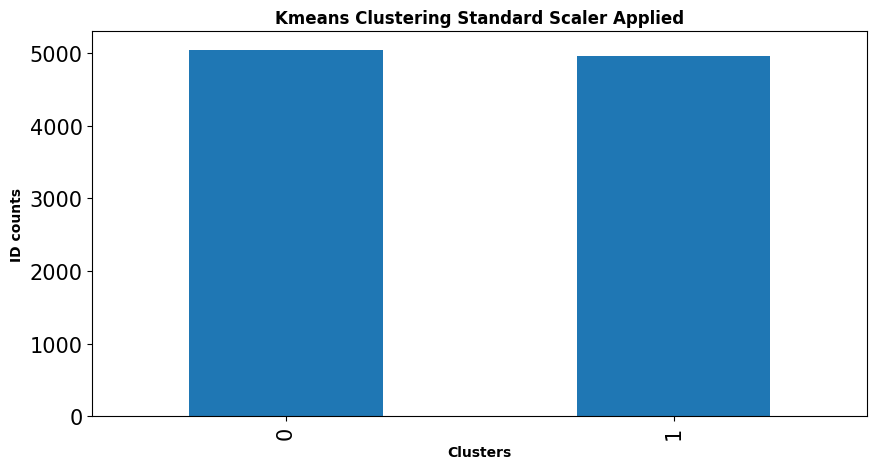

In [90]:
fig, ax = plt.subplots(figsize=(10,5))
dftrain_clu2.groupby(['Kmeans_Label']).count()['Previous Scores'].plot(kind='bar')
plt.ylabel('ID Counts')
plt.title('Kmeans Clustering Standard Scaler Applied',fontsize='large',fontweight='bold')
ax.set_xlabel('Clusters', fontsize='medium', fontweight='bold')
ax.set_ylabel('ID counts', fontsize='medium', fontweight='bold')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

#### KMeans Cluster algorithm using K= 3

In [91]:
dftrain_clu3.groupby('Kmeans_Label').agg(['mean'])

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
,mean,mean,mean,mean,mean,mean
Kmeans_Label,,,,,,
0,4.790132,52.637480,0.491545,6.470697,4.513783,37.417188
1,2.672231,82.664643,0.481411,6.636950,4.441578,62.108877
2,7.287824,81.823761,0.510994,6.523466,4.804398,74.499180


##### vẽ biểu đồ để phân tích số lượng mỗi cụm k= 3


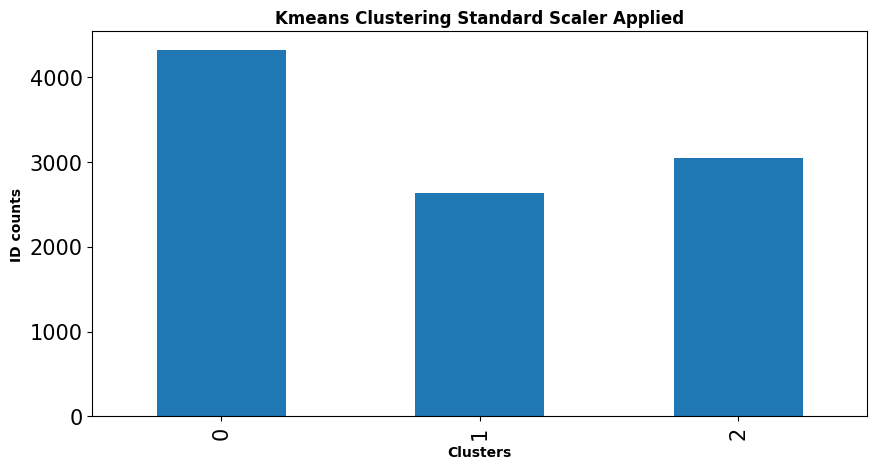

In [92]:
fig, ax = plt.subplots(figsize=(10,5))
dftrain_clu3.groupby(['Kmeans_Label']).count()['Previous Scores'].plot(kind='bar')
plt.ylabel('ID Counts')
plt.title('Kmeans Clustering Standard Scaler Applied',fontsize='large',fontweight='bold')
ax.set_xlabel('Clusters', fontsize='medium', fontweight='bold')
ax.set_ylabel('ID counts', fontsize='medium', fontweight='bold')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

##### KMeans Cluster algorithm using K= 4

In [93]:
dftrain_clu4.groupby('Kmeans_Label').agg(['mean'])

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
,mean,mean,mean,mean,mean,mean
Kmeans_Label,,,,,,
0,4.816451,55.109673,0.000000,6.494669,4.441356,39.725438
1,2.681465,85.873684,0.461785,6.686499,4.449428,65.444394
2,7.323462,84.100000,0.519231,6.487692,4.863462,76.904615
3,4.782155,55.405562,1.000000,6.478563,4.558903,40.548861


##### vẽ biểu đồ để phân tích số lượng mỗi cụm k= 4


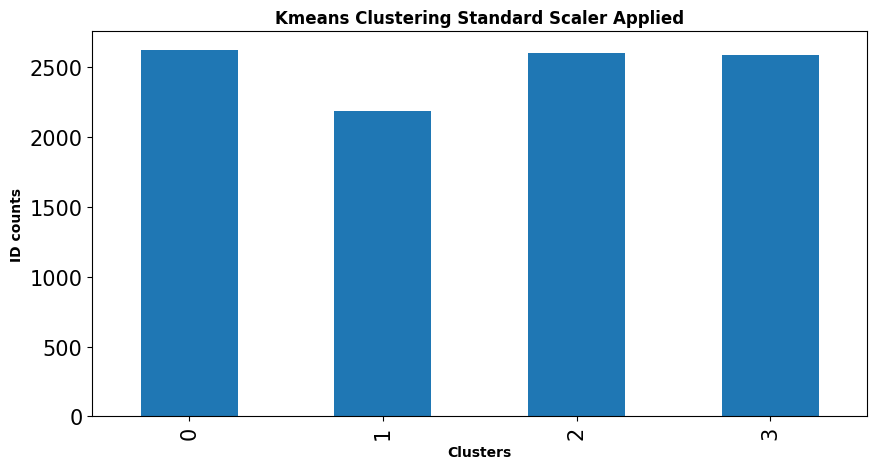

In [94]:
fig, ax = plt.subplots(figsize=(10,5))
dftrain_clu4.groupby(['Kmeans_Label']).count()['Previous Scores'].plot(kind='bar')
plt.ylabel('ID Counts')
plt.title('Kmeans Clustering Standard Scaler Applied',fontsize='large',fontweight='bold')
ax.set_xlabel('Clusters', fontsize='medium', fontweight='bold')
ax.set_ylabel('ID counts', fontsize='medium', fontweight='bold')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

#### Phân tích và đánh giá 
- Phân cụm với k = 2 nó không đem lại quá nhiều giá trị cho phân tích, vì các phân tử trong cụm đang có hiện tượng chồng chéo lên nhau,
- Phân cụm với k = 3 nó đã khả quan hơn, nhưng số lượng trong mỗi cụm lệch khá lớn.
- Phân cụm với k = 4 đã chia ra phần cụm 0 của k=3 cho nê số lượng ở mỗi cụm đều nhau, và các chỉ số ở mỗi cụm đem lại khá nhiều thông tin để phân tích.
##### => chọn k=4 để phân cụm, phân tích và đánh giá.


### 3.4 Đánh giá và phân tích kết quả sau khi phân cụm.


In [95]:
dftrain_clu4.groupby('Kmeans_Label').agg(['mean'])

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
,mean,mean,mean,mean,mean,mean
Kmeans_Label,,,,,,
0,4.816451,55.109673,0.000000,6.494669,4.441356,39.725438
1,2.681465,85.873684,0.461785,6.686499,4.449428,65.444394
2,7.323462,84.100000,0.519231,6.487692,4.863462,76.904615
3,4.782155,55.405562,1.000000,6.478563,4.558903,40.548861


##### Trực quan hóa các cụm đã chia để thấy sự phân bố của các cụm.

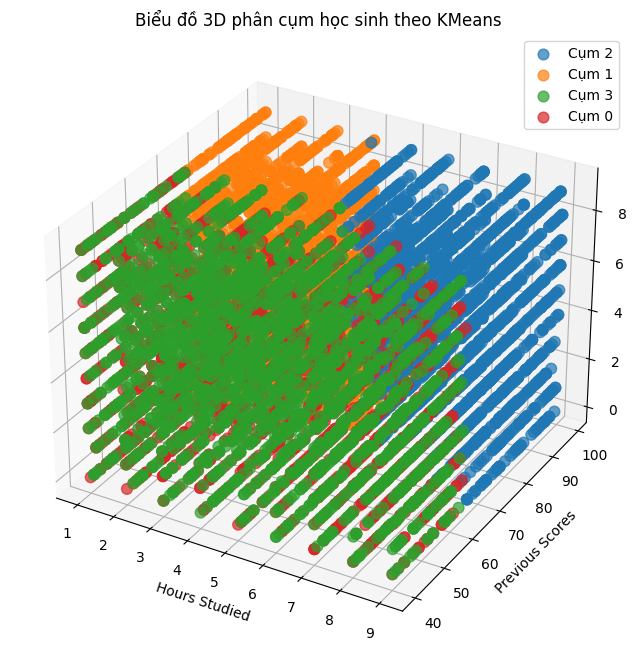

In [96]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

dftrain_clu = dftrain_clu4
# Thiết lập bảng màu theo số cụm
colors = sns.color_palette("Set2", dftrain_clu['Kmeans_Label'].nunique())

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Vẽ từng cụm
for cluster in dftrain_clu['Kmeans_Label'].unique():
    subset = dftrain_clu[dftrain_clu['Kmeans_Label'] == cluster]
    ax.scatter(
        subset['Hours Studied'],
        subset['Previous Scores'],
        subset['Sample Question Papers Practiced'],
        label=f'Cụm {cluster}',
        s=60,
        alpha=0.7
    )

# Gán nhãn trục và tiêu đề
ax.set_xlabel('Hours Studied')
ax.set_ylabel('Previous Scores')
ax.set_zlabel('Performance Index')
ax.set_title('Biểu đồ 3D phân cụm học sinh theo KMeans')
ax.legend()
plt.show()


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


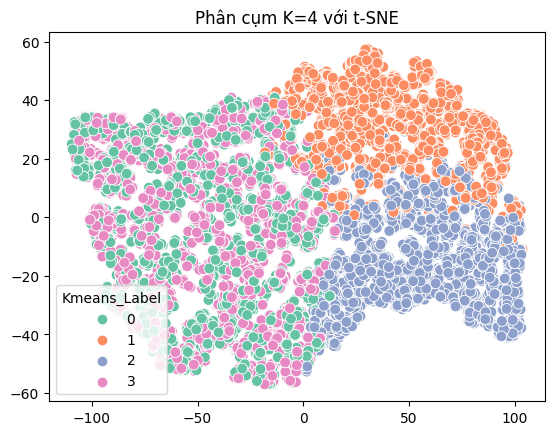

In [97]:
from sklearn.manifold import TSNE

X = dftrain_clu4.drop(columns='Kmeans_Label')
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X)

sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=dftrain_clu4['Kmeans_Label'], palette='Set2', s=60)
plt.title("Phân cụm K=4 với t-SNE")
plt.show()


##### Đánh giá: có thể thấy thuật toán và dữ liệu đã chia ra các cụm khá là ổn chúng ta sẽ tiến hành Đánh giá và phân tích hành vi học tập của học sinh dựa trên các thông số các cụm đã thu được.

### 3.5 Đánh giá và phân tích hành vi học tập của học sinh dựa trên kết quả phân cụm thu được.

In [98]:
dftrain_clu4.groupby('Kmeans_Label').agg(['mean'])

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
,mean,mean,mean,mean,mean,mean
Kmeans_Label,,,,,,
0,4.816451,55.109673,0.000000,6.494669,4.441356,39.725438
1,2.681465,85.873684,0.461785,6.686499,4.449428,65.444394
2,7.323462,84.100000,0.519231,6.487692,4.863462,76.904615
3,4.782155,55.405562,1.000000,6.478563,4.558903,40.548861


Cụm 0 – “Thiếu động lực học tập”
- Điểm xuất phát và thành tích đều thấp, nhưng thời gian học chỉ ở mức trung bình.

- Không tham gia ngoại khoá → ít kỹ năng hỗ trợ (quản lí thời gian, hợp tác…).
-   Khuyến nghị:

    + Học kèm/mentoring để lấy lại kiến thức nền.

    + Lộ trình học cụ thể, dùng kỹ thuật Pomodoro để tăng giờ học hữu ích.

    + Bổ sung hoạt động nhóm nhỏ (study‑group) để tạo động lực và trách nhiệm.

Cụm 1 – “Thông minh nhưng thiếu đầu tư”
- Điểm trước đây cao nhưng giờ học thấp nhất. Thành tích chỉ ở mức khá, chứng tỏ lệ thuộc vào năng lực sẵn có.

- Ngoại khoá vừa phải → phân tán thêm quỹ thời gian.
- Khuyến nghị:

    -   Coaching về mục tiêu dài hạn để khơi lại động lực.

    -   Khuyến khích giữ nhịp ngoại khoá nhưng đặt giới hạn (giờ học tối thiểu / tuần).

    -   nên dành nhiều thời dành nhiều thời gian học để đạt điểm số cao hơn.

Cụm 2 – “Học sinh xuất sắc, cân bằng”
- Giờ học cao, điểm nền cao, luyện đề nhiều nhất → thành tích cao nhất.

- Vẫn dành ≈ 0,5 cho ngoại khoá và ngủ đủ ~6,5 h → quản lí thời gian tốt.
-   Khuyến nghị:

    - Chương trình nâng cao (advanced projects, Olympic, nghiên cứu khoa học).

    - Trao vai trò dẫn dắt nhóm hoặc mentoring cho bạn khác (giữ động lực, lan toả thực hành tốt).

    - Theo dõi để tránh kiệt sức; đảm bảo duy trì chất lượng giấc ngủ.

Cụm 3 – “Năng nổ ngoại khoá, điểm thấp”
- Tham gia ngoại khoá tuyệt đối (1,0) nhưng điểm & thành tích thấp tương tự cụm 0.

- Giờ học tương đương cụm 0, có thể mất cân đối giữa hoạt động xã hội và học thuật.
- Khuyến nghị:

    - Định hướng lại mục tiêu: phân tách rõ thời gian học vs ngoại khoá.

    - Có thể dành nhiều thời gian học hơn để cải thiện điểm số, hiệu suất học tập.

    - Tận dụng kỹ năng ngoại khoá (làm việc nhóm, lãnh đạo) vào học – ví dụ tổ chức nhóm giải đề.

### 4. Sửa dụng DBSCAN để phân cụm.

#### 4.1 Tìm các chỉ số cần thiết để phân cụm bằng DBSCAN

In [99]:
from itertools import product
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
eps_values = np.arange(1.0, 5, 0.4)  # từ 1.0 đến 3.0, bước 0.2
     # 1.0 đến 2.5
min_samples = np.arange(3,22)              # 3 đến 7

DBSCAN_params = list(product(eps_values, min_samples))

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

sil_score = []
no_of_clusters = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(data_scaled_std)
    labels = DBS_clustering.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    no_of_clusters.append(n_clusters)

    if n_clusters >= 2:
        score = silhouette_score(data_scaled_std[labels != -1], labels[labels != -1])
        sil_score.append(score)
    else:
        sil_score.append(None)
        print(f"❌ Không đủ cụm tại eps={p[0]}, min_samples={p[1]}")


❌ Không đủ cụm tại eps=2.1999999999999997, min_samples=3
❌ Không đủ cụm tại eps=2.1999999999999997, min_samples=4
❌ Không đủ cụm tại eps=2.1999999999999997, min_samples=5
❌ Không đủ cụm tại eps=2.1999999999999997, min_samples=6
❌ Không đủ cụm tại eps=2.1999999999999997, min_samples=7
❌ Không đủ cụm tại eps=2.1999999999999997, min_samples=8
❌ Không đủ cụm tại eps=2.1999999999999997, min_samples=9
❌ Không đủ cụm tại eps=2.1999999999999997, min_samples=10
❌ Không đủ cụm tại eps=2.1999999999999997, min_samples=11
❌ Không đủ cụm tại eps=2.1999999999999997, min_samples=12
❌ Không đủ cụm tại eps=2.1999999999999997, min_samples=13
❌ Không đủ cụm tại eps=2.1999999999999997, min_samples=14
❌ Không đủ cụm tại eps=2.1999999999999997, min_samples=15
❌ Không đủ cụm tại eps=2.1999999999999997, min_samples=16
❌ Không đủ cụm tại eps=2.1999999999999997, min_samples=17
❌ Không đủ cụm tại eps=2.1999999999999997, min_samples=18


A heatplot shows how many clusters were genreated by the algorithm for the respective parameters combinations.


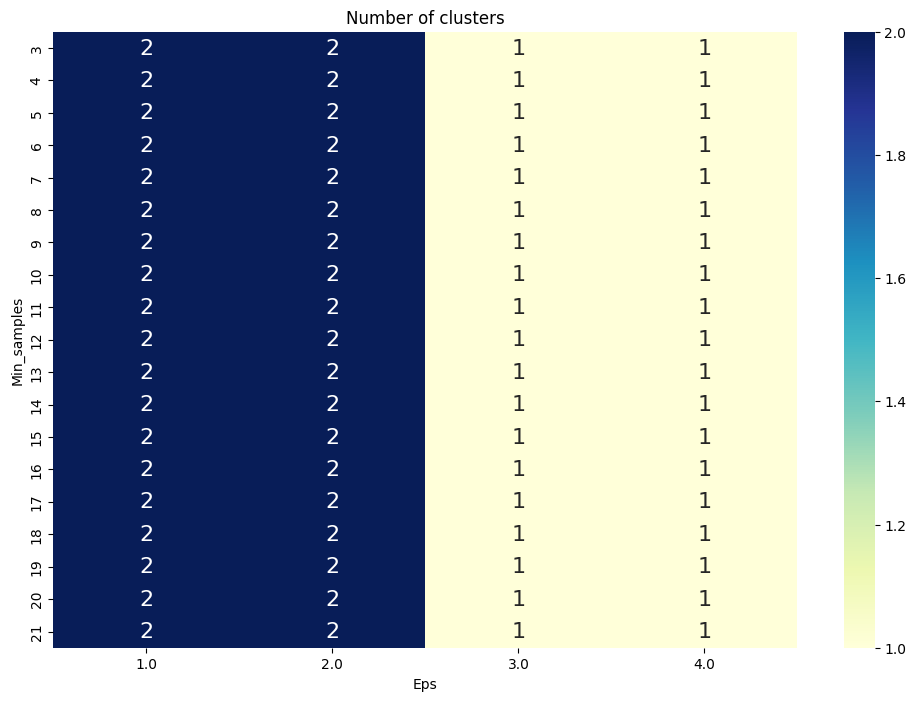

In [ ]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters
pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
print('A heatplot shows how many clusters were genreated by the algorithm for the respective parameters combinations.')
plt.show()

#### 4.2 Tiến hành phân cụm với eps = 0.5 và min_samples = 4

In [ ]:
dbscan = DBSCAN(eps=0.25, min_samples=6)
dbscan.fit(data_scaled_std)

DBSCAN(eps=0.25, min_samples=6)

In [ ]:
dftrain_DBSCAN = dftrain.copy(deep = True)
dftrain_DBSCAN['DBSCAN_Labels'] = dbscan.labels_
dftrain_DBSCAN.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index,DBSCAN_Labels
0,7,99,1,9,1,91.0,-1
1,4,82,0,4,2,65.0,-1
2,8,51,1,7,2,45.0,-1
3,5,52,1,5,2,36.0,-1
4,7,75,0,8,5,66.0,-1


In [ ]:
dftrain_DBSCAN.groupby('DBSCAN_Labels').agg(['mean'])

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
,mean,mean,mean,mean,mean,mean
DBSCAN_Labels,,,,,,
-1,4.989534,69.430814,0.494214,6.53014,4.580859,55.198249
0,7.000000,62.166667,1.000000,4.00000,7.000000,55.166667
1,3.000000,94.333333,1.000000,7.00000,1.000000,73.500000
2,2.000000,61.714286,1.000000,9.00000,4.000000,39.428571
3,8.000000,58.142857,0.000000,6.00000,6.000000,52.142857
4,5.000000,60.833333,0.000000,8.00000,8.000000,47.833333
5,8.000000,97.333333,0.000000,9.00000,6.000000,95.333333
6,8.000000,57.571429,0.000000,5.00000,3.000000,50.428571


#### 4.3 kiểm tra phân bố của các cụm

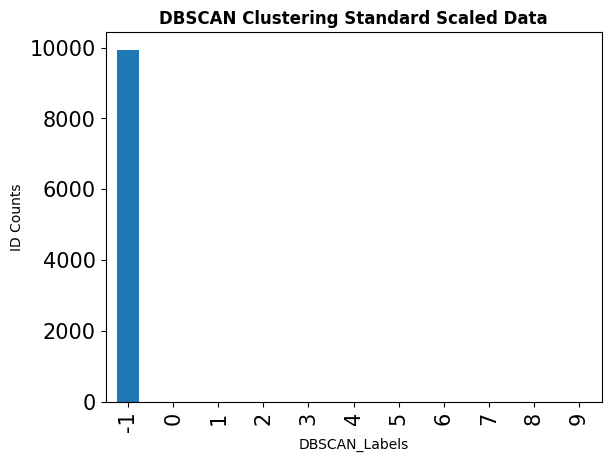

In [ ]:
dftrain_DBSCAN.groupby(['DBSCAN_Labels']).count()['Hours Studied'].plot(kind='bar')
plt.ylabel('ID Counts')
plt.title('DBSCAN Clustering Standard Scaled Data',fontsize='large',fontweight='bold')
ax.set_xlabel('Clusters', fontsize='large', fontweight='bold')
ax.set_ylabel('ID counts', fontsize='large', fontweight='bold')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

#### 4.3 Tính silhouette score

In [ ]:
from sklearn.metrics import silhouette_score

# Lấy nhãn cụm từ kết quả DBSCAN bạn đã lưu
labels = dftrain_DBSCAN['DBSCAN_Labels'].values

# Loại bỏ điểm nhiễu (-1), vì silhouette không hỗ trợ
mask = labels != -1

# Kiểm tra có đủ cụm để tính hay không
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

if n_clusters >= 2:
    sil_score = silhouette_score(data_scaled_std[mask], labels[mask])
    print(f"✅ Silhouette Score: {sil_score:.4f}")
else:
    print("❌ Không đủ cụm hợp lệ để tính Silhouette Score.")


✅ Silhouette Score: 0.8540


#### 4.4 Trực quan hóa

C:\Users\Admin\AppData\Local\Temp\ipykernel_17684\1748933362.py:27: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


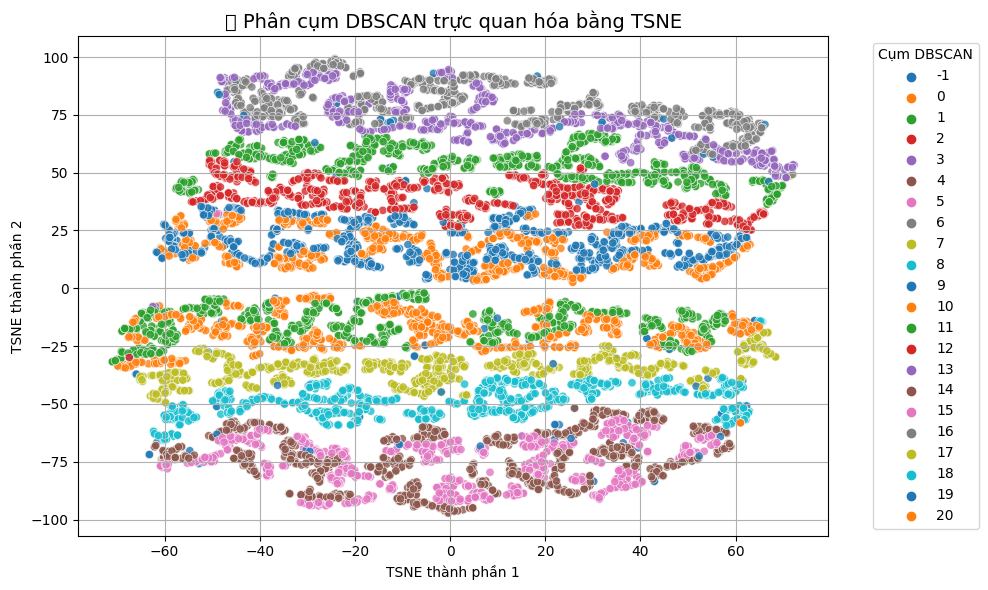

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# TSNE để giảm chiều dữ liệu chuẩn hóa
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate='auto', init='pca')
tsne_result = tsne.fit_transform(data_scaled_std)

# Thêm kết quả TSNE vào DataFrame
dftrain_DBSCAN['TSNE_1'] = tsne_result[:, 0]
dftrain_DBSCAN['TSNE_2'] = tsne_result[:, 1]

# Vẽ scatter plot các cụm
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=dftrain_DBSCAN,
    x='TSNE_1', y='TSNE_2',
    hue='DBSCAN_Labels',
    palette='tab10',
    alpha=0.8
)
plt.title('🔍 Phân cụm DBSCAN trực quan hóa bằng TSNE', fontsize=14)
plt.xlabel('TSNE thành phần 1')
plt.ylabel('TSNE thành phần 2')
plt.legend(title='Cụm DBSCAN', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


#### 4.5 Phân tích và đánh giá mô hình.
- mô hình đem lại chỉ số đánh giá chất lượng phân cụm khá thấp (Silhouette Score) với -0.1203 thấp hơn với thuật toán Kmean,
và theo mô hình trực quan hóa thì chất lượng chia thực sự không phù hợp.
=> nên mô hình này không hiệu quả cho việc phân cụm với bộ dữ liệu này.